# Run Metaneighbor
Salomé Carcy, 27 August 2024

## 1. IMPORT
### 1.1. Import librairies
All the information to download the pyMN (pymetaneighbor) package can be found here: https://github.com/gillislab/pyMN

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import pymn

Set working directory.

In [ ]:
import os
os.chdir("/Users/scarcy/Projects/HumanThymusProject/")
os.getcwd()

### 1.2. Import data

In [24]:
# anndata object
adata = sc.read_h5ad('./data_github/cross_species/innateT_ms_hu_full_seu_240826.h5ad')   
print(adata)

AnnData object with n_obs × n_vars = 53656 × 11120
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'study', 'clusters_to_compare'
    var: 'features'


In [8]:
# highly variable genes
hvg = pd.read_csv(r'./data_github/cross_species/innateT_ms_hu_list_hvg_240826.csv', index_col=0)
hvg.head()

,features,highly_variable
1,EIF2S3B,True
2,CDH2,False
3,CEP120,True
4,CSNK1G3,False
5,ALDH7A1,False


## 2. RUN METANEIGHBOR
### 2.1. Prepare data

In [25]:
# Make sure observation columns of interest are strings
adata.obs['study'] = adata.obs['study'].astype(str)
adata.obs['clusters_to_compare'] = adata.obs['clusters_to_compare'].astype(str)
print(adata.obs.head())

                          orig.ident  nCount_RNA  nFeature_RNA  study  \
B6NKT_AAACCTGAGATACACA-1           1      4362.0          1692  Mouse   
B6NKT_AAACCTGAGCTGGAAC-1           1      2752.0          1136  Mouse   
B6NKT_AAACCTGAGGCTCTTA-1           1      2176.0          1044  Mouse   
B6NKT_AAACCTGAGTTCCACA-1           1      2716.0          1200  Mouse   
B6NKT_AAACCTGGTACAGTGG-1           1      1972.0           922  Mouse   

                         clusters_to_compare  
B6NKT_AAACCTGAGATACACA-1               typeI  
B6NKT_AAACCTGAGCTGGAAC-1               typeI  
B6NKT_AAACCTGAGGCTCTTA-1               typeI  
B6NKT_AAACCTGAGTTCCACA-1               typeI  
B6NKT_AAACCTGGTACAGTGG-1               typeI  


In [26]:
# add HVGs to anndata object
adata.var = pd.merge(adata.var, hvg, on=['features'], how='inner')
adata.var.index.name = 'features'
adata.var.index = adata.var.index.astype(str) # overcome error message
print(adata.var.head())
print(adata.var.highly_variable.value_counts()) # should have 4284 HVGs

         features  highly_variable
features                          
0         EIF2S3B             True
1            CDH2            False
2          CEP120             True
3         CSNK1G3            False
4         ALDH7A1            False
False    6836
True     4284
Name: highly_variable, dtype: int64


/Users/scarcy/opt/anaconda3/envs/humanthymusproj/lib/python3.11/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [28]:
# subset anndata object to only HVGs
adatasub = adata[:,adata.var['highly_variable']]
print(adatasub) # 4284 features

View of AnnData object with n_obs × n_vars = 53656 × 4284
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'study', 'clusters_to_compare'
    var: 'features', 'highly_variable'


### 2.2. Run MetaNeighbor

In [29]:
pymn.MetaNeighborUS(
    adatasub,
    study_col='study',
    ct_col='clusters_to_compare',
    fast_version=True
)

/Users/scarcy/opt/anaconda3/envs/humanthymusproj/lib/python3.11/site-packages/pymn/MetaNeighborUS.py:130: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[mn_key] = cell_nv


### 2.3. Quick look at output

In [30]:
print(adatasub.uns['MetaNeighborUS'].head())

                        Mouse|12  Mouse|cycling  Mouse|immature_CD24_GD  \
Mouse|12                0.977631       0.140647                0.718012   
Mouse|cycling           0.140647       0.985088                0.614617   
Mouse|immature_CD24_GD  0.718012       0.614617                0.995214   
Mouse|post_selection    0.807079       0.364693                0.884229   
Mouse|signaling         0.423113       0.592362                0.677679   

                        Mouse|post_selection  Mouse|signaling  \
Mouse|12                            0.807079         0.423113   
Mouse|cycling                       0.364693         0.592362   
Mouse|immature_CD24_GD              0.884229         0.677679   
Mouse|post_selection                0.942986         0.667341   
Mouse|signaling                     0.667341         0.986640   

                        Mouse|transition  Mouse|typeI  Mouse|typeII  \
Mouse|12                        0.102355     0.713747      0.203310   
Mouse|cycling   

/Users/scarcy/opt/anaconda3/envs/humanthymusproj/lib/python3.11/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


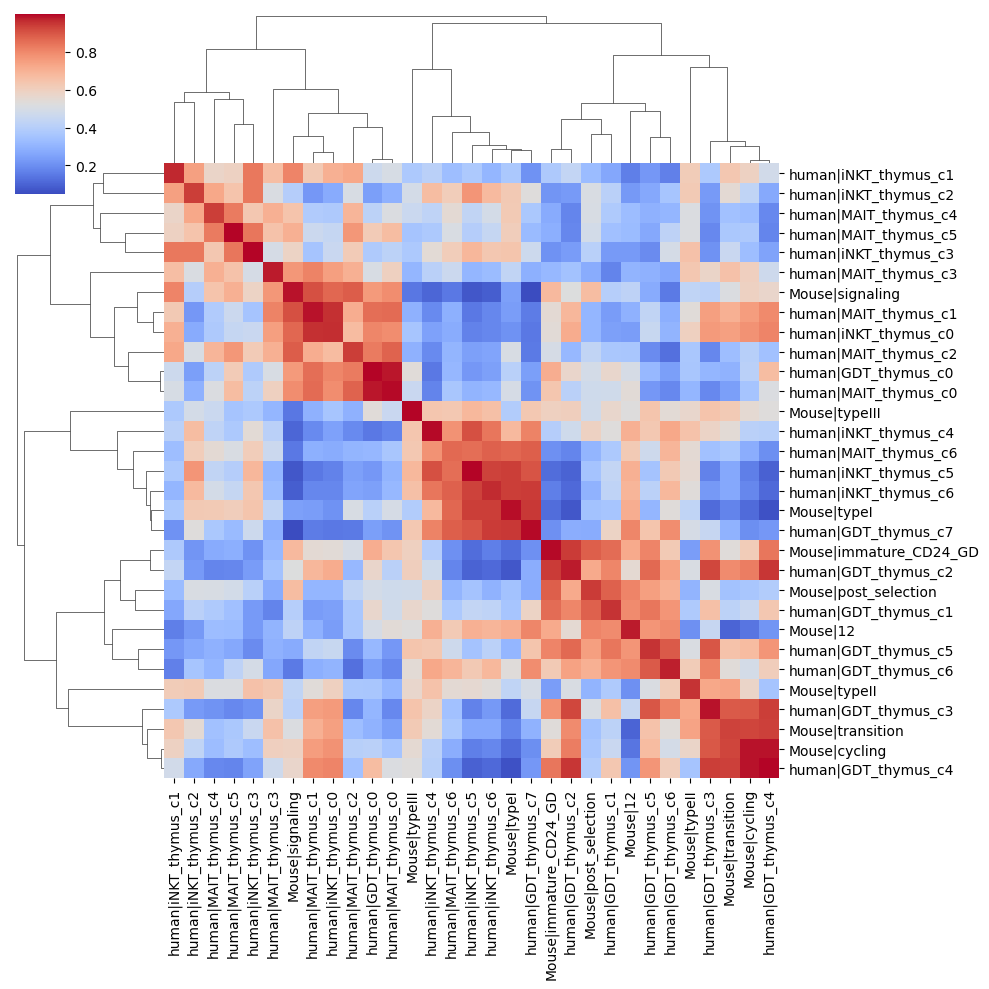

In [31]:
pymn.plotMetaNeighborUS(adatasub, figsize=(10, 10), cmap='coolwarm', fontsize=10)

### 2.4. Save output

In [32]:
adatasub.uns['MetaNeighborUS'].to_csv("./data_github/cross_species/innateT_ms_hu_pymtn_output_2024_08_27.csv")